In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

from matplotlib import pyplot as plt

sns.set()

In [2]:
#convert_dates is "False" because of a bug in pandas, see: https://github.com/pandas-dev/pandas/issues/33787
t_df = pd.read_json(".\\tropical_job.2020-11-05\\topics_combined_processed.json", lines=True,convert_dates=False)
u_df = pd.read_json(".\\ubc_threads_combined.json",lines=True,convert_dates=False)
#df
dfs = [t_df,u_df]

In [3]:
t_df.rename({'parentLink':'threadID'},axis='columns',inplace=True)

In [4]:
u_df.rename({'thread_id':'threadID'},axis='columns',inplace=True)

In [5]:
#extract data from arrays, i.e. removing the brackets around the array

for column in ['username','dateTime','postID','mainText','threadID']:
    for df in dfs:
        df[column] = df[column].str[0]

In [6]:
t_df['threadID'] = t_df['threadID'].str.split('=').str[-1]

In [7]:
t_df['dateTime_raw'] = pd.to_datetime(t_df['dateTime'],format=' %B %d, %Y, %I:%M:%S %p »',errors='coerce')

In [8]:
u_df['dateTime_raw'] = pd.to_datetime(u_df['dateTime'],format='%b %d, %Y at %I:%M %p')

In [9]:
for df in dfs:
    df.drop(['timestamp','dateTime'],axis='columns',inplace=True)

In [10]:
for df in dfs:
    df['week'] = df['dateTime_raw'].dt.to_period('W')

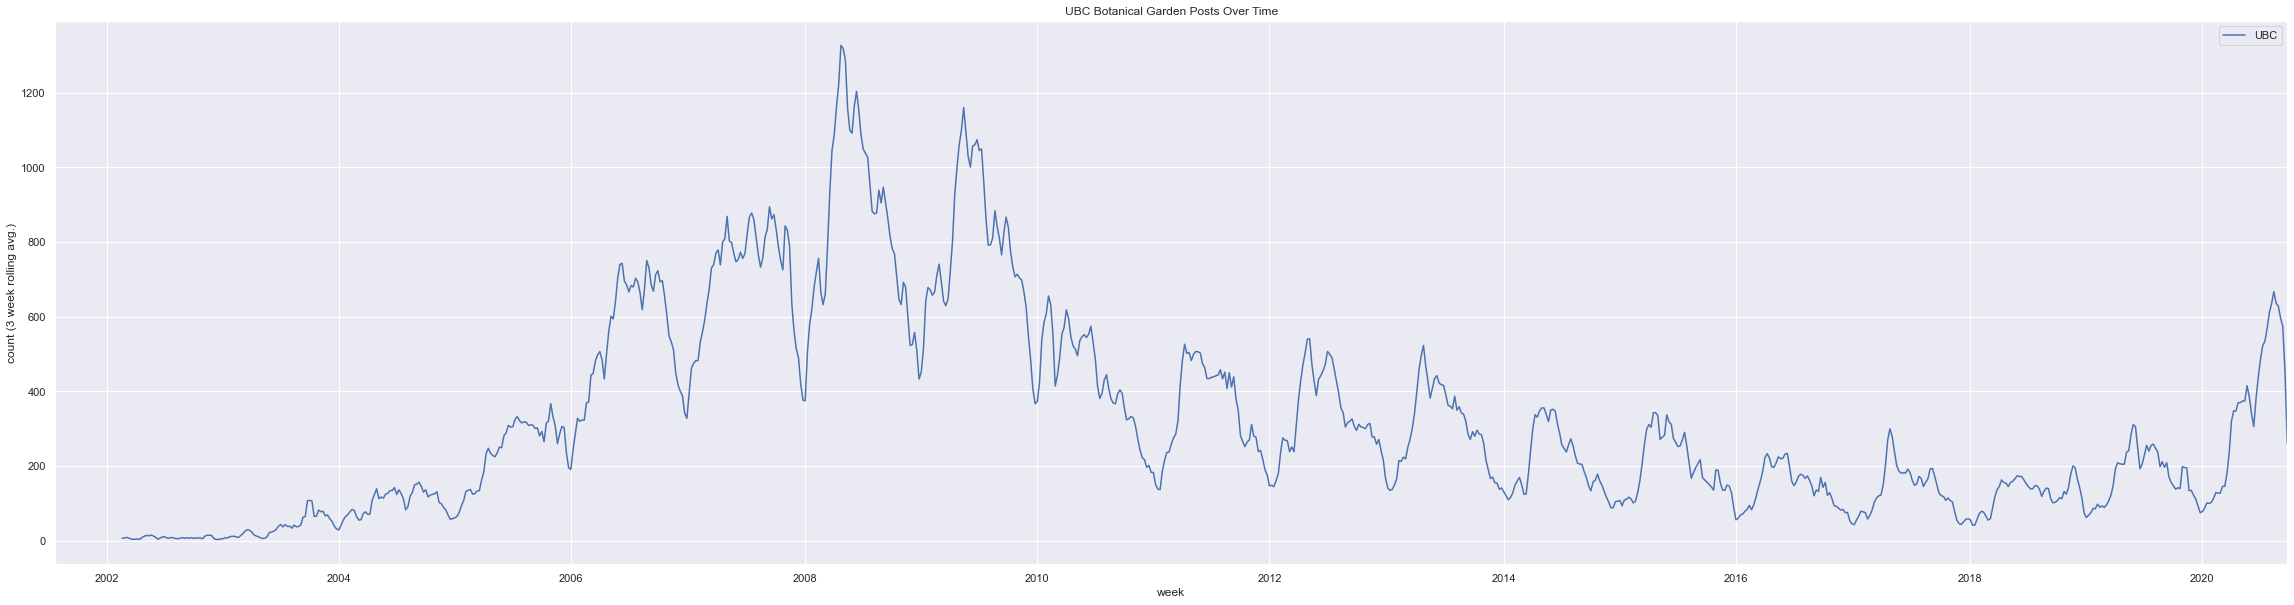

In [48]:
fig, ax = plt.subplots(figsize=(40,10))

weekly_posts = u_df.groupby('week', as_index = False).count()
weekly_posts['count_rolling'] = weekly_posts['postID'].rolling(3).mean()
weekly_posts.plot(ax=ax,x='week',y='count_rolling',label='UBC',title='UBC Botanical Garden Posts Over Time')

plt.ylabel('count (3 week rolling avg.)')
plt.savefig('UBC_weekly_rolling.png')

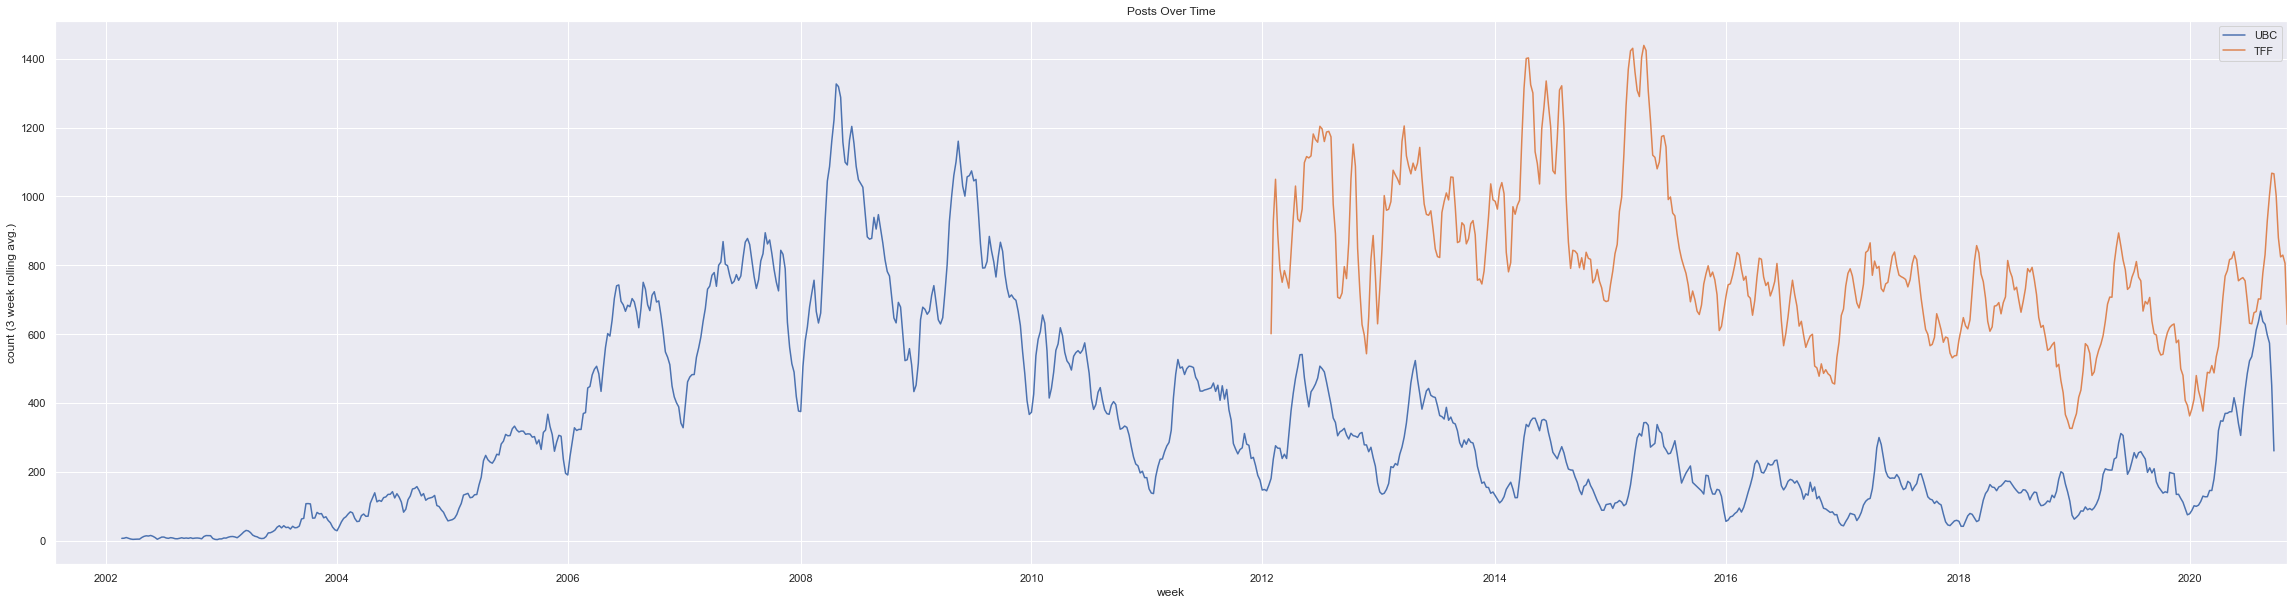

In [50]:
fig, ax = plt.subplots(figsize=(40,10))

weekly_posts = u_df.groupby('week', as_index = False).count()
weekly_posts['count_rolling'] = weekly_posts['postID'].rolling(3).mean()
weekly_posts.plot(ax=ax,x='week',y='count_rolling',label='UBC',title='Posts Over Time')

weekly_posts = t_df.groupby('week', as_index = False).count()
weekly_posts['count_rolling'] = weekly_posts['postID'].rolling(3).mean()
weekly_posts.plot(ax=ax,x='week',y='count_rolling',label='TFF')

plt.ylabel('count (3 week rolling avg.)')
plt.savefig('compare_weekly_rolling.png')

In [12]:
def cdf(graphdf, stat, graph_title, xlimit, log=False):
    cdf_df = graphdf.groupby(stat)[stat].agg('count').pipe(pd.DataFrame).rename(columns = {stat: 'frequency'})
    cdf_df['pdf'] = cdf_df['frequency'] / sum(cdf_df['frequency'])
    cdf_df['cdf'] = cdf_df['pdf'].cumsum()
    cdf_df.reset_index(inplace=True)
    cdf_df.plot(x=stat, y = ['cdf','pdf'], title = graph_title, figsize=(15,15), xlim=xlimit,logx=log)
    return cdf_df

,count,frequency,pdf,cdf
0,1,8933,0.146079,0.146079
1,2,9881,0.161581,0.307660
2,3,12504,0.204474,0.512134
3,4,7650,0.125098,0.637232
4,5,5733,0.093750,0.730982
...,...,...,...,...
139,376,1,0.000016,0.999935
140,396,1,0.000016,0.999951
141,484,1,0.000016,0.999967
142,499,1,0.000016,0.999984


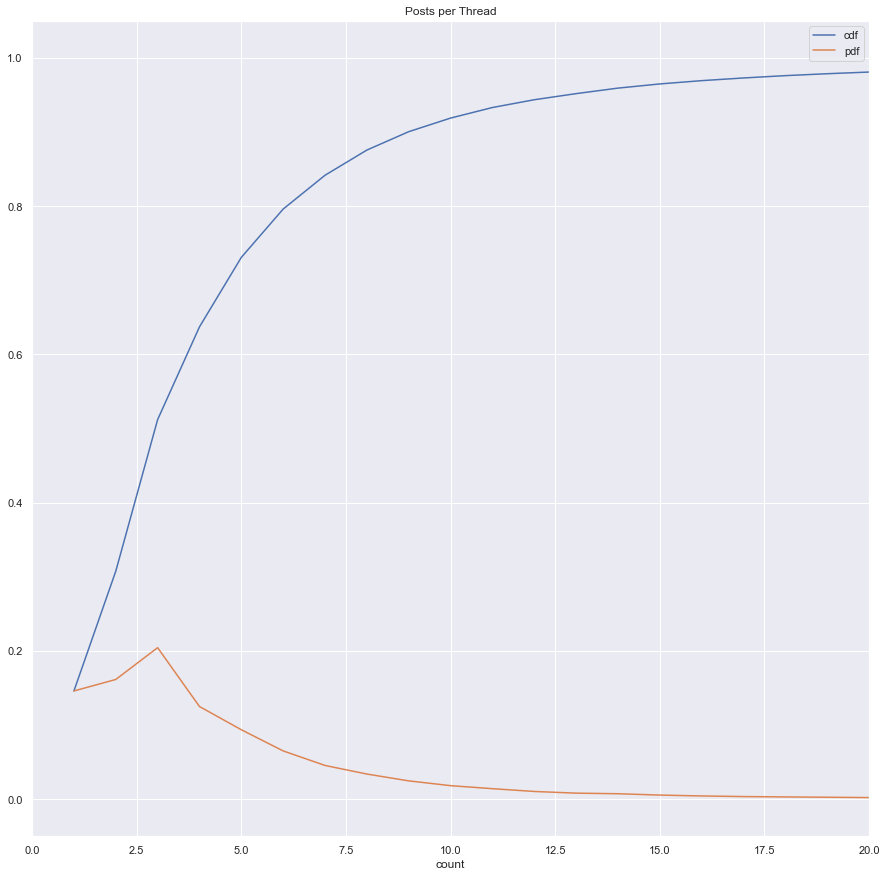

In [52]:
posts_df = u_df.groupby('threadID').count().rename(columns = {'postID' : 'count'})
cdf(posts_df,'count','Posts per Thread',[0,20])

,username,frequency,pdf,cdf
0,1,9792,0.160126,0.160126
1,2,21200,0.346677,0.506803
2,3,14237,0.232813,0.739616
3,4,7687,0.125703,0.865319
4,5,3831,0.062647,0.927966
...,...,...,...,...
34,37,3,0.000049,0.999935
35,38,1,0.000016,0.999951
36,42,1,0.000016,0.999967
37,63,1,0.000016,0.999984


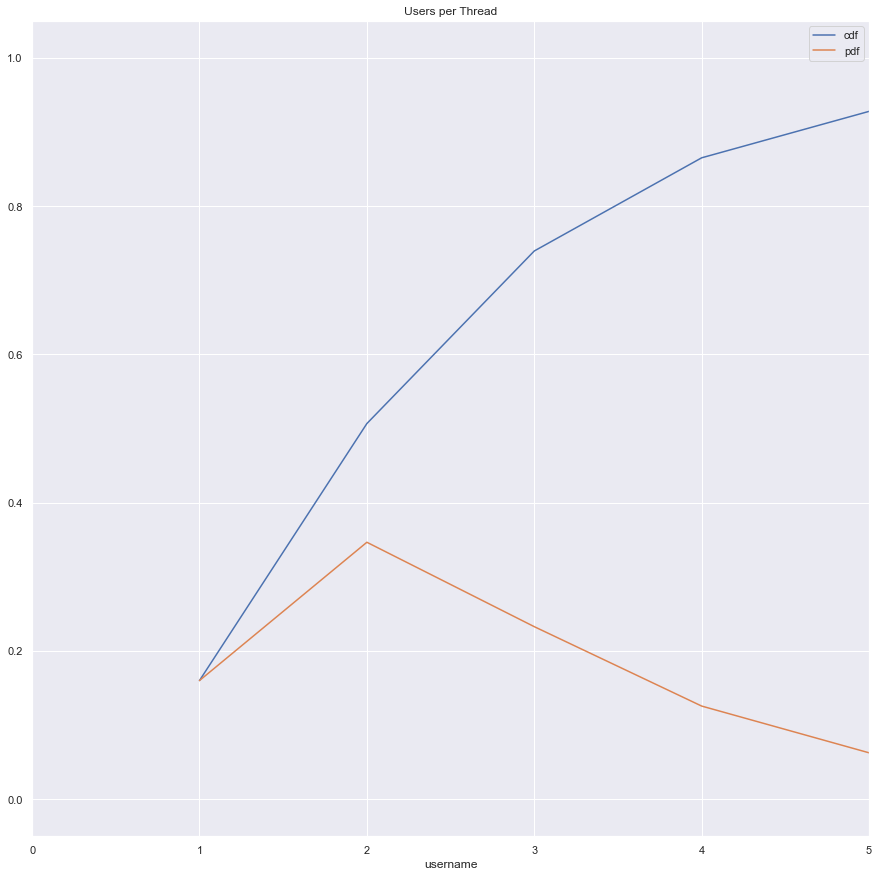

In [129]:
user_df = u_df.groupby('threadID')['username'].nunique()
user_df = pd.DataFrame(user_df)
cdf(user_df,'username','Users per Thread',[0,5])

,days,frequency,pdf,cdf
0,0,33270,0.544054,0.544054
1,1,6674,0.109138,0.653192
2,2,3335,0.054536,0.707728
3,3,2058,0.033654,0.741382
4,4,1410,0.023057,0.764439
...,...,...,...,...
2229,6097,2,0.000033,0.999935
2230,6161,1,0.000016,0.999951
2231,6201,1,0.000016,0.999967
2232,6205,1,0.000016,0.999984


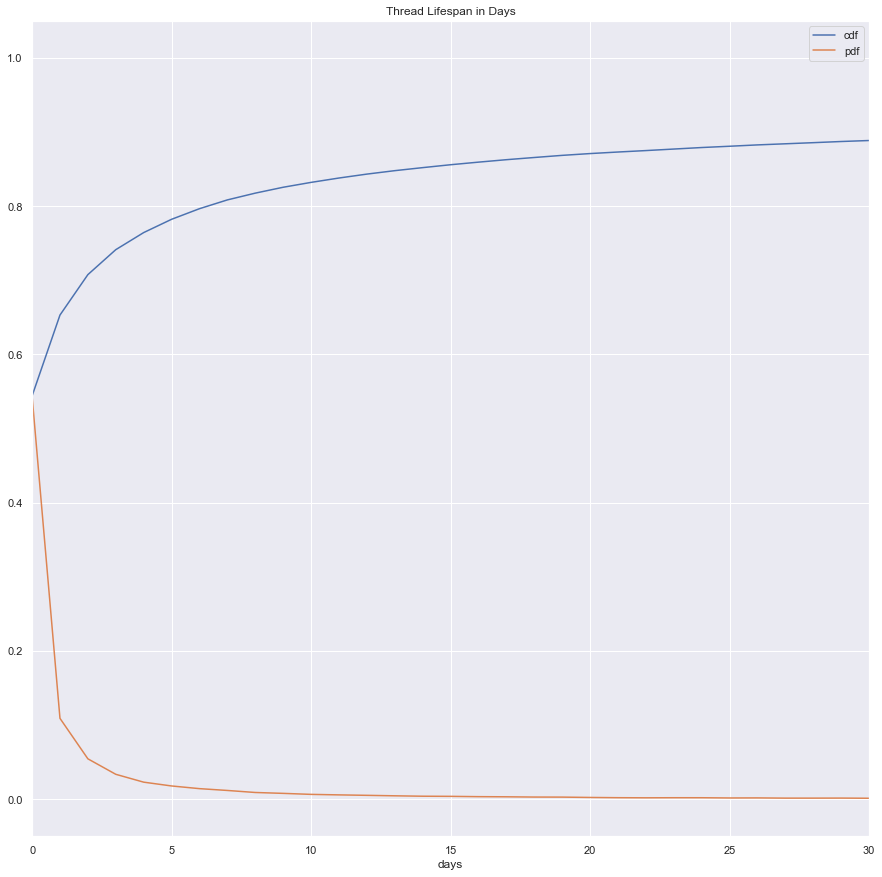

In [65]:
lifespan_df = u_df.groupby('threadID')['dateTime_raw'].agg(['min','max']).diff(axis=1).rename(columns = {'max' : 'days'})
lifespan_df['days'] = lifespan_df['days'].apply(lambda x: pd.Timedelta(x).days)
cdf(lifespan_df,'days','Thread Lifespan in Days',[0,30])

,characters,frequency,pdf,cdf
0,1,328,0.195938,0.195938
1,2,152,0.090800,0.286738
2,3,73,0.043608,0.330346
3,4,76,0.045400,0.375747
4,5,52,0.031063,0.406810
...,...,...,...,...
442,3009,1,0.000597,0.997611
443,3029,1,0.000597,0.998208
444,3058,1,0.000597,0.998805
445,3250,1,0.000597,0.999403


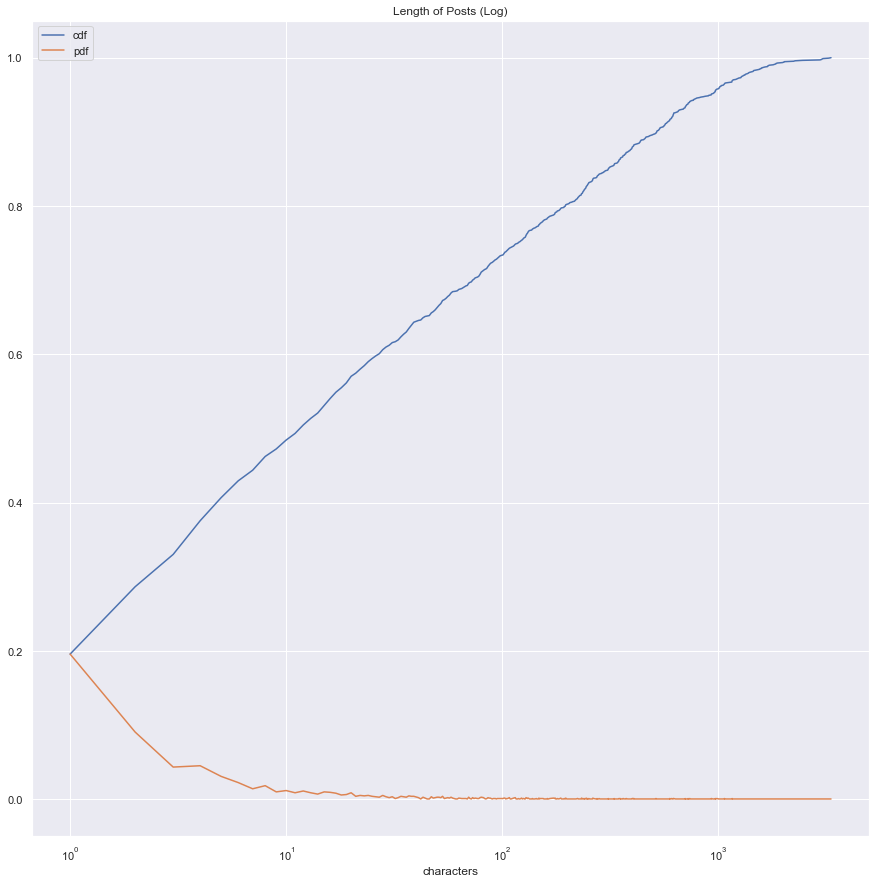

In [13]:
u_df['post_length'] = u_df['mainText'].str.len()
length_df = u_df.groupby('post_length').count().rename(columns = {'postID' : 'characters'})
cdf(length_df,'characters','Length of Posts (Log)',None,log=True)

[Text(0.5, 0, 'Hour of Day'), Text(0, 0.5, 'Posts')]

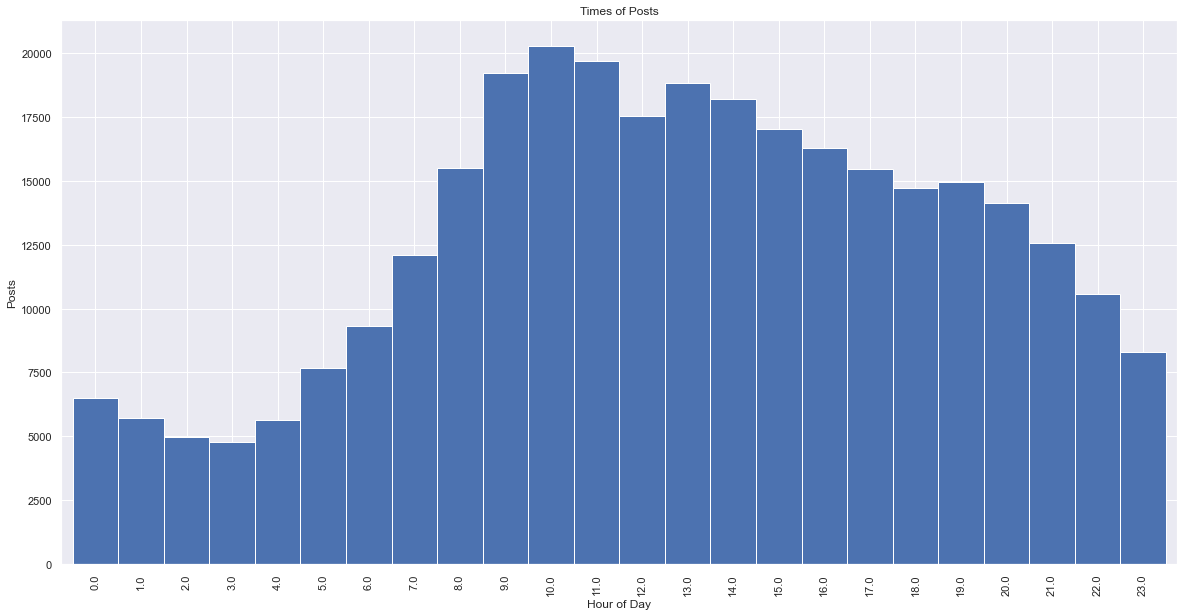

In [86]:
#u_df['hour'] = u_df['dateTime_raw'].dt.hour
#hour_df = u_df.groupby('hour').count().rename(columns = {'postID' : 'count'})
#plt.bar(hour_df.index, hour_df['count'])
#ax = u_df['hour'].plot.hist(bins=24,title='Times of Posts',figsize=(20,10))
#ax.set(xlabel='Hour of Day',ylabel='Posts')
u_df['hour'] = u_df['dateTime_raw'].dt.hour
ax = df.groupby('hour')['postID'].count().plot(kind='bar',width=1,title='Times of Posts',figsize=(20,10))
ax.set(xlabel='Hour of Day',ylabel='Posts')

,posts,frequency,pdf,cdf
0,1,11255,0.376069,0.376069
1,2,8111,0.271017,0.647086
2,3,3398,0.113539,0.760626
3,4,1873,0.062584,0.823209
4,5,1083,0.036187,0.859396
...,...,...,...,...
316,5328,1,0.000033,0.999866
317,8763,1,0.000033,0.999900
318,9033,1,0.000033,0.999933
319,9843,1,0.000033,0.999967


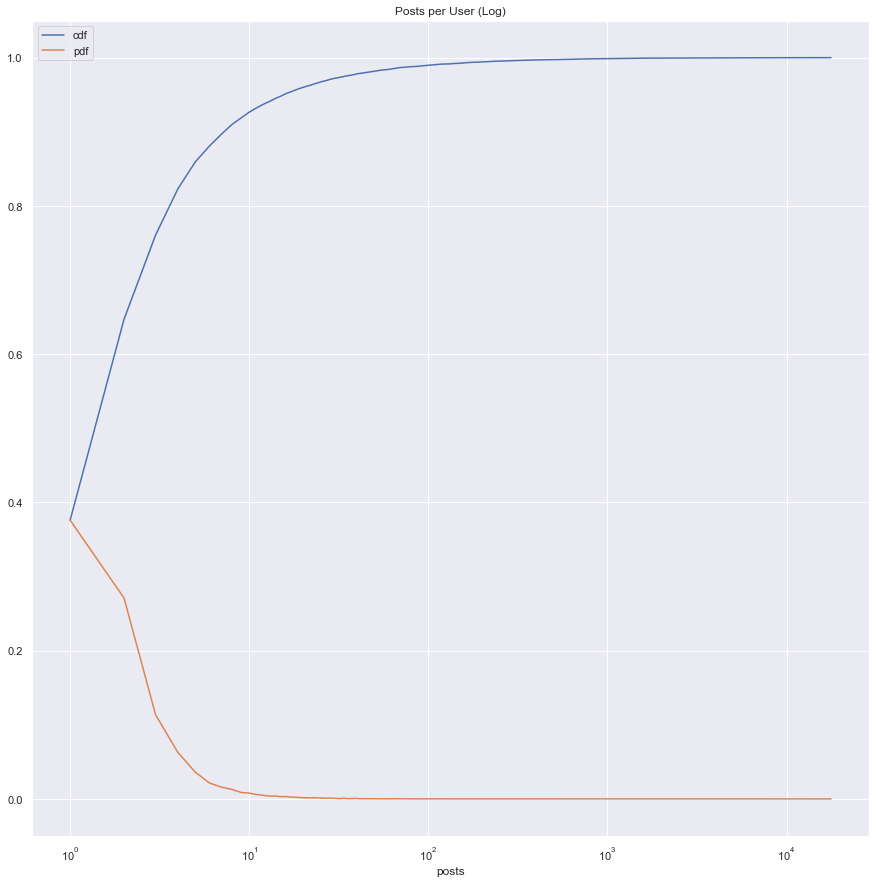

In [92]:
user_posts_df = df.groupby('username').count().rename(columns = {'postID' : 'posts'})
cdf(user_posts_df,'posts','Posts per User (Log)',None,log=True)

,posts,frequency,pdf,cdf
0,1,110,0.016933,0.016933
1,2,85,0.013085,0.030018
2,3,81,0.012469,0.042488
3,4,77,0.011853,0.054341
4,5,82,0.012623,0.066964
...,...,...,...,...
210,229,1,0.000154,0.999230
211,234,2,0.000308,0.999538
212,235,1,0.000154,0.999692
213,250,1,0.000154,0.999846


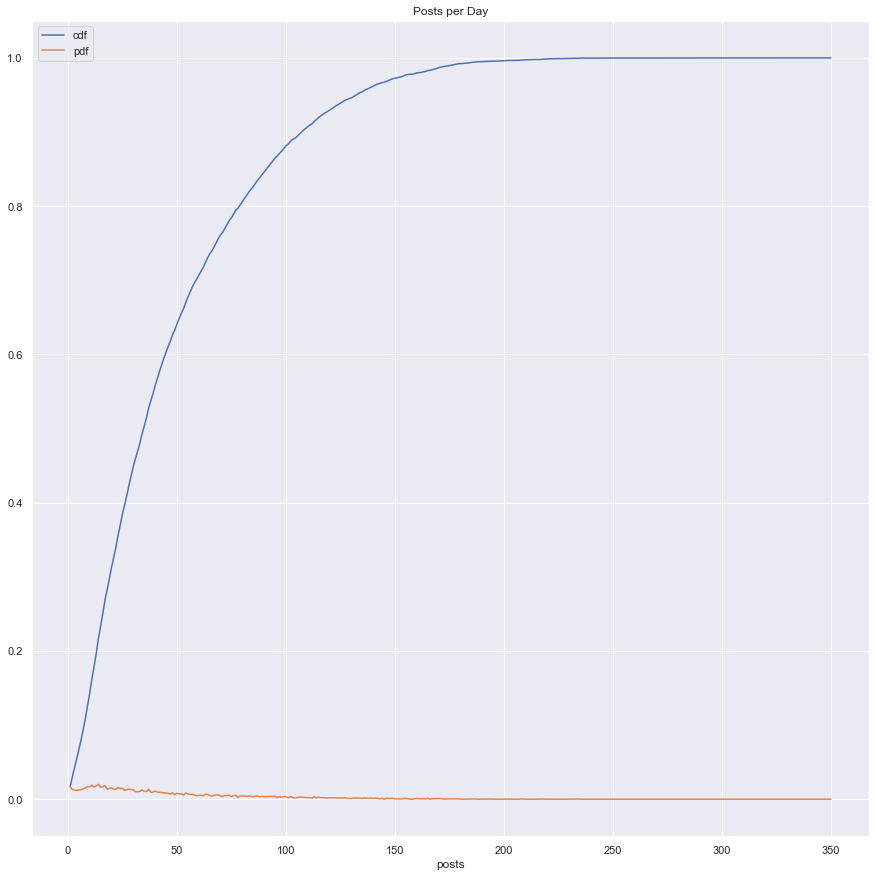

In [83]:
u_df['day'] = u_df['dateTime_raw'].dt.to_period('D')
daily_posts_df = u_df.groupby('day').count().rename(columns = {'postID' : 'posts'})
cdf(daily_posts_df,'posts','Posts per Day',None)

,days,frequency,pdf,cdf
0,0,18565,0.620322,0.620322
1,1,1849,0.061782,0.682104
2,2,938,0.031342,0.713446
3,3,598,0.019981,0.733427
4,4,376,0.012563,0.745990
...,...,...,...,...
2068,6189,1,0.000033,0.999866
2069,6492,1,0.000033,0.999900
2070,6535,1,0.000033,0.999933
2071,6849,1,0.000033,0.999967


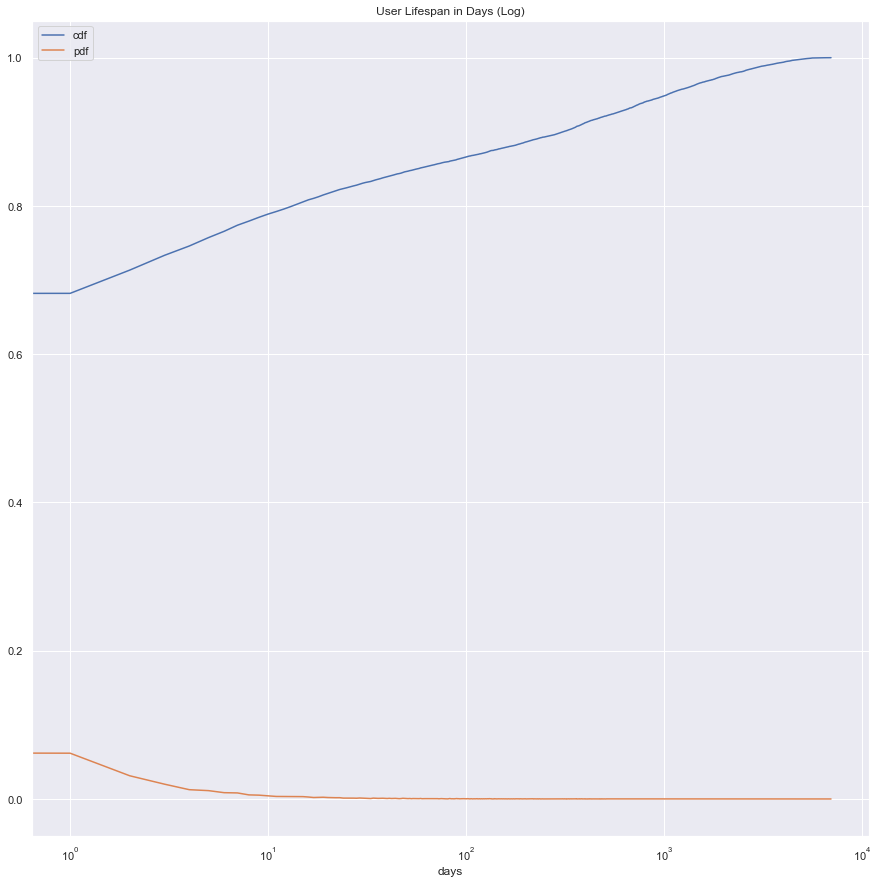

In [14]:
lifespan_user_df = u_df.groupby('username')['dateTime_raw'].agg(['min','max']).diff(axis=1).rename(columns = {'max' : 'days'})
lifespan_user_df['days'] = lifespan_user_df['days'].apply(lambda x: pd.Timedelta(x).days)
cdf(lifespan_user_df,'days','User Lifespan in Days (Log)',None,log=True)

In [123]:
threads = u_df.groupby('threadID',as_index = False)['dateTime_raw'].min()
threads['week'] = threads['dateTime_raw'].dt.to_period('W')

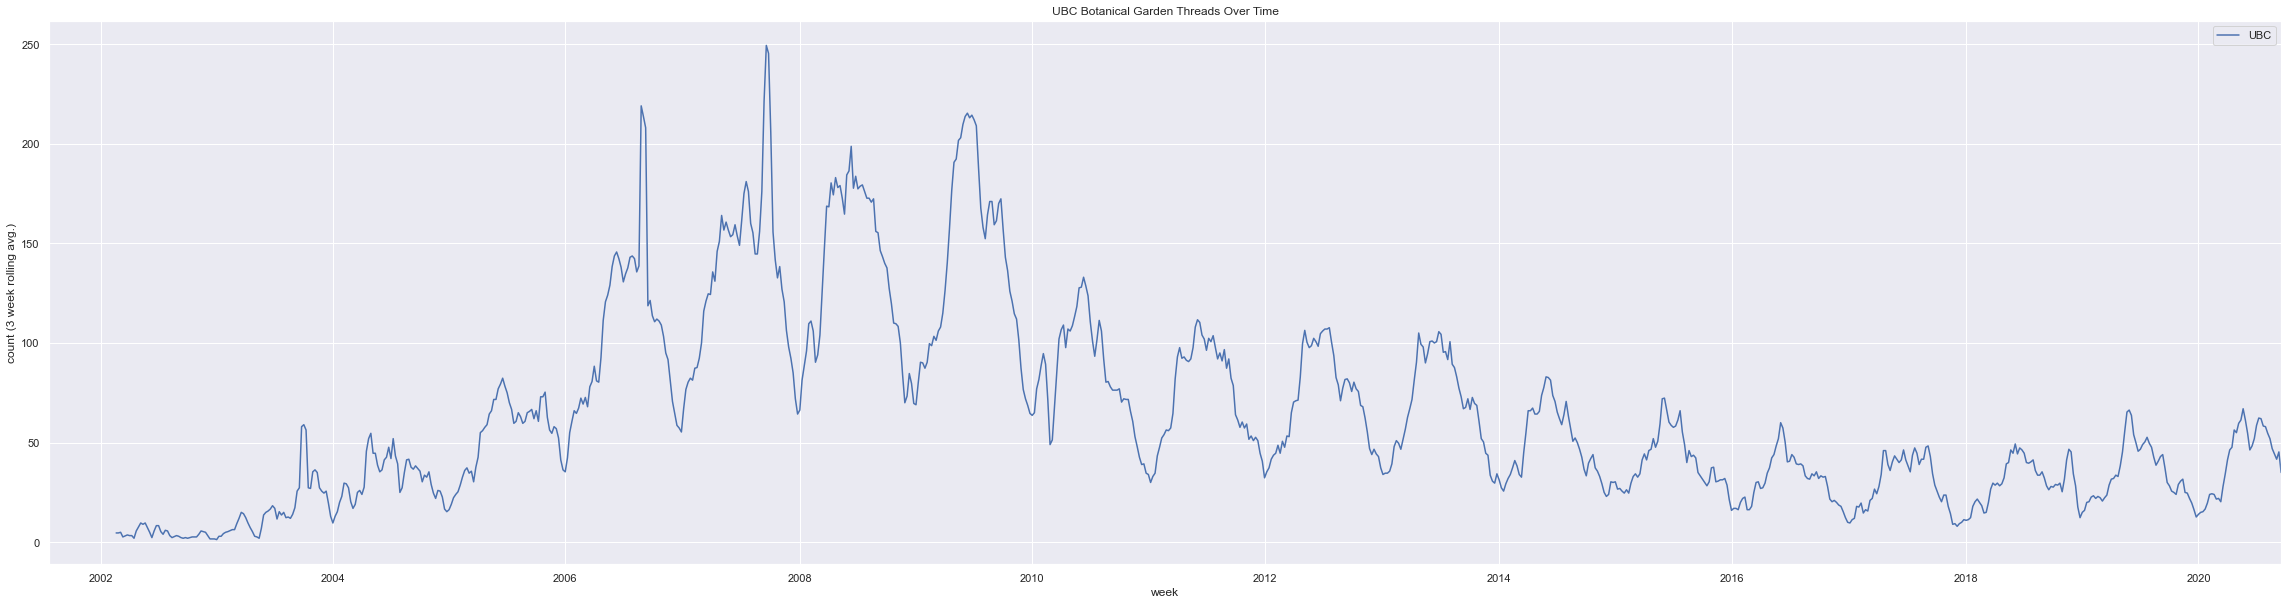

In [124]:
fig, ax = plt.subplots(figsize=(40,10))
weekly_posts = threads.groupby('week', as_index = False).count()
weekly_posts['count_rolling'] = weekly_posts['threadID'].rolling(3).mean()
weekly_posts.plot(ax=ax,x='week',y='count_rolling',label='UBC',title='UBC Botanical Garden Threads Over Time')

plt.ylabel('count (3 week rolling avg.)')
plt.savefig('UBC_threads_weekly_rolling.png')

In [125]:
t_threads = t_df.groupby('threadID',as_index = False)['dateTime_raw'].min()
t_threads['week'] = t_threads['dateTime_raw'].dt.to_period('W')

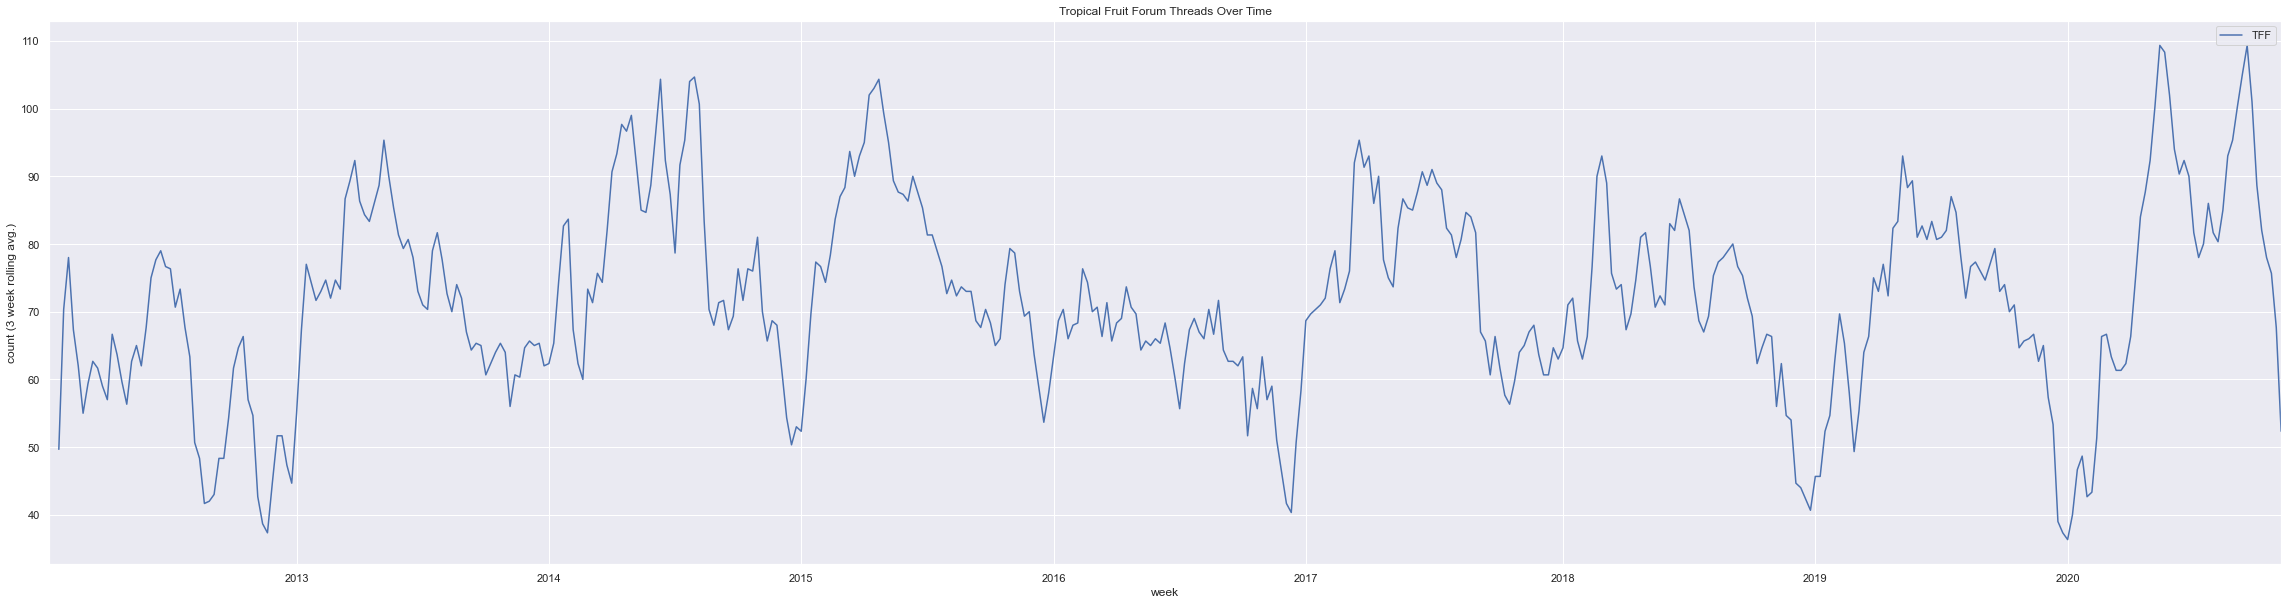

In [126]:
fig, ax = plt.subplots(figsize=(40,10))
weekly_posts = t_threads.groupby('week', as_index = False).count()
weekly_posts['count_rolling'] = weekly_posts['threadID'].rolling(3).mean()
weekly_posts.plot(ax=ax,x='week',y='count_rolling',label='TFF',title='Tropical Fruit Forum Threads Over Time')

plt.ylabel('count (3 week rolling avg.)')
plt.savefig('tropical_threads_weekly_rolling.png')

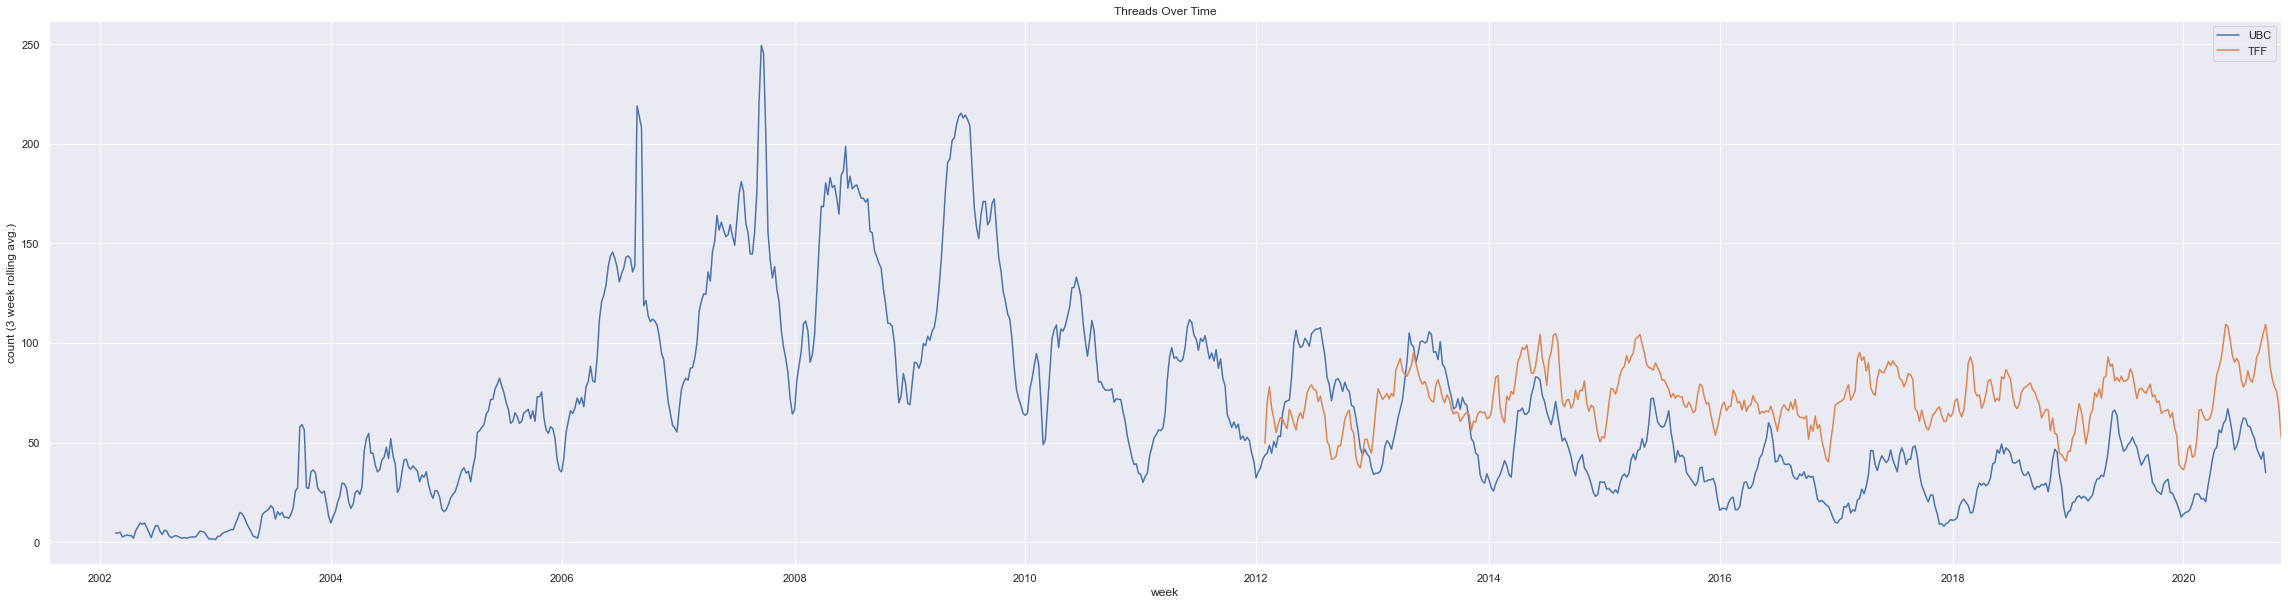

In [127]:
fig, ax = plt.subplots(figsize=(40,10))

weekly_posts = threads.groupby('week', as_index = False).count()
weekly_posts['count_rolling'] = weekly_posts['threadID'].rolling(3).mean()
weekly_posts.plot(ax=ax,x='week',y='count_rolling',label='UBC',title='Threads Over Time')

weekly_posts = t_threads.groupby('week', as_index = False).count()
weekly_posts['count_rolling'] = weekly_posts['threadID'].rolling(3).mean()
weekly_posts.plot(ax=ax,x='week',y='count_rolling',label='TFF')

plt.ylabel('count (3 week rolling avg.)')
plt.savefig('compare_threads_weekly_rolling.png')